# Human RNA editing landscape of REDIportal (GPU-based)

### Part V Extract clusters from large dataset via computer visulization

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- opencv==4.5.5.62

## Introduction

For hardware issue, we cannot compute the clusters with over 5 million sites efficienctly (yes, you can run HDBSCAN with multi-core CPU for hours). Based on the mechanism of HDBSCAN, we can use an approximate computer visulization methods to extract the spots in the figure.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tracemalloc
import scipy.stats
import sys, os
import cv2
from collections import defaultdict
# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

import time
time0 = time.time()

In [70]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column=("INFO", "motif_F10"), draw_logos=True):
    print("===============  {}  ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = [-1] + [i for i in range(0, int(df[cluster_col].max())+1)]
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            #os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P '' -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            #os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            #os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [ ]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if os.path.getsize(prefix+"/"+img) == 0:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 2 * cols
        height = 1 * rows
        #width = 2 * cols
        #height = 1 * rows
        figsize = (width, height)
    
    if len(file_list_format) > 1:
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("cluster #{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        fig, ax = plt.subplots(figsize=figsize)
        fn, id = file_list_format[0]
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster #{}".format(id),size=16)
        ax.axis("off")
    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.05, wspace=0.05)

In [5]:
def draw_2D_hist(df, vmax=0.05, norm = None, cmin = None,
                 density = True, xlim = [-16, 16],
                 ylim = [-16, 16], bins = [600, 600]):
    fig, ax = plt.subplots(figsize=[6,6])
    ax.set_aspect('equal', 'box')
    hist2d, edgesX, edgesY, ax_hist = ax.hist2d(df["X"], df["Y"], range=[xlim, ylim], vmax=vmax, bins=bins, cmin=cmin, density=density, norm=norm)
    
    # small trick here, the x,y row/col is different in figure and numpy, let's make it the same as we view
    hist2d = np.rot90(hist2d)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    return hist2d, edgesX, edgesY

In [6]:
def hist_to_spots(hist2d, density=True, cutoff = 5, bins=[600, 600], pixel_lower = 1, pixel_upper = 10, show_big_clusters_id=True):
    hist2d = hist2d.copy()
    cutoff = int(cutoff)
    
    # cutoff, how low the number/density will be discard
    if density == True:
        hist2d = hist2d/(hist2d.max()/255.0)
    else:
        hist2d[hist2d>=255] = 255
    hist2d = hist2d.astype('uint8')
    hist2d_raw = hist2d.copy()
    
    thresh = cv2.threshold(hist2d, cutoff, 255, cv2.THRESH_BINARY)[1]
   
    thresh_small = hist2d_raw.copy()
    thresh_small[thresh_small>cutoff] = 0
    thresh_small[thresh_small>0] = 255
    
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) # 
    contours_filtered_small = []
    contours_filtered_big = []
    dropped = []
    
    N = 0
    show_contours_small =np.zeros(bins).astype('uint8')
    show_contours_big =  np.zeros(bins).astype('uint8')
    dict_cnt_big = defaultdict(list)
    dict_cnt_small = defaultdict(list)
    
    mask =np.zeros(bins).astype('uint8')
    stistics = {"big_pixels":0, "big_cnt": 0, "small_pixels":0, "small_cnt":0, "ignored_pixels":0, "ignored_cnt":0}
    for cnt in contours:
        if pixel_lower <cv2.contourArea(cnt)< pixel_upper:
            contours_filtered_small.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg, k = 1)
            pts = np.where(cimg_rot90 == 255)
            stistics["small_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["small_pixels"] += 1
                dict_cnt_small[int(stistics["small_cnt"])].append((bins[0]-i, j))
        elif cv2.contourArea(cnt) >= pixel_upper:
            contours_filtered_big.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg)
            pts = np.where(cimg_rot90 == 255)
            stistics["big_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["big_pixels"] += 1
                dict_cnt_big[stistics["big_cnt"]].append((bins[0]-i, j))
        else:
            dropped.append(cnt)
            for item in cnt:
                stistics["ignored_cnt"] += 1
                for x,y in item:
                    c = hist2d_raw[x, y]
                    stistics["ignored_pixels"] += c
                        
    print("Pixels ignored: {} pixels in {} cntours".format(stistics["ignored_pixels"], stistics["ignored_cnt"]))
    print("Big contours: {} pixels in {} cntours".format(stistics["big_pixels"], stistics["big_cnt"]))
    print("Small contour: {} piexels in {} cntours".format(stistics["small_pixels"], stistics["small_cnt"]))
    image = cv2.bitwise_and(thresh, thresh, mask=mask)

    cv2.drawContours(show_contours_small, contours_filtered_small, -1, 255, -1)
    cv2.drawContours(show_contours_big, contours_filtered_big, -1, 255, -1)
    cv2.drawContours(thresh_small, dropped, -1, 255, -1)

    fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(12,12))
    axes[0][0].imshow(thresh_small)
    axes[0][1].imshow(show_contours_small)
    axes[1][0].imshow(show_contours_big)
    axes[1][1].imshow(thresh)
    axes[0][0].set_title("Ignored pixels")
    axes[0][1].set_title("Small clusters")
    axes[1][0].set_title("Big clusters")
    axes[1][1].set_title("Thresh")
    axes[0][0].set_xticks([]) # 
    axes[0][0].set_yticks([]) #
    
    if show_big_clusters_id == True:
        for id, xy in dict_cnt_big.items():
            Xs = []
            Ys = []
            for x, y in xy:
                Xs.append(x)
                Ys.append(y)
            c_X = np.mean(Xs)
            c_Y = np.mean(Ys)
            
            diameter_X = np.max(Xs) - np.min(Xs)
            diameter_Y = np.max(Ys) - np.min(Ys)
            
            if diameter_X * diameter_Y >= 250:
                color = "red"
            else:
                color = "white"
            axes[1][0].annotate(str(id), xy=(c_X, c_Y), c=color, ha="center", va="center") 
            
        for id, xy in dict_cnt_small.items():
            Xs = []
            Ys = []
            for x, y in xy:
                Xs.append(x)
                Ys.append(y)
            c_X = np.mean(Xs)
            c_Y = np.mean(Ys)
            
            diameter_X = np.max(Xs) - np.min(Xs)
            diameter_Y = np.max(Ys) - np.min(Ys)
            
            if diameter_X * diameter_Y >= 250:
                color = "red"
            else:
                color = "white"
            axes[0][1].annotate(str(id), xy=(c_X, c_Y), c=color, ha="center", va="center") 
            
            
    '''
    for id, xy in dict_cnt_small.items():
        Xs = []
        Ys = []
        for x, y in xy:
            Xs.append(x)
            Ys.append(y)
        c_X = np.mean(Xs)
        c_Y = np.mean(Ys)
        axes[0][1].annotate(str(id), xy=(c_X, c_Y), c="white") # , ha="center", va="center"
    '''
    plt.tight_layout() 
    return dict_cnt_small, dict_cnt_big


In [7]:
def hist_to_spots_2(hist2d, density=True, cutoff = 5, bins=[600, 600], pixel_lower = 1, pixel_upper = 10, show_big_clusters_id=True):
    hist2d = hist2d.copy()
    cutoff = int(cutoff)
    
    # cutoff, how low the number/density will be discard
    if density == True:
        hist2d = hist2d/(hist2d.max()/255.0)
    else:
        hist2d[hist2d>=255] = 255
    hist2d = hist2d.astype('uint8')
    hist2d_raw = hist2d.copy()
    
    thresh = cv2.threshold(hist2d, cutoff, 255, cv2.THRESH_BINARY)[1]
   
    thresh_small = hist2d_raw.copy()
    thresh_small[thresh_small>cutoff] = 0
    thresh_small[thresh_small>0] = 255
    
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) # 
    contours_filtered_small = []
    contours_filtered_big = []
    dropped = []
    
    N = 0
    show_contours_small =np.zeros(bins).astype('uint8')
    show_contours_big =  np.zeros(bins).astype('uint8')
    dict_cnt_big = defaultdict(list)
    dict_cnt_small = defaultdict(list)
    
    mask =np.zeros(bins).astype('uint8')
    stistics = {"big_pixels":0, "big_cnt": 0, "small_pixels":0, "small_cnt":0, "ignored_pixels":0, "ignored_cnt":0}
    for cnt in contours:
        if pixel_lower <cv2.contourArea(cnt)< pixel_upper:
            contours_filtered_small.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg, k = 1)
            pts = np.where(cimg_rot90 == 255)
            stistics["small_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["small_pixels"] += 1
                dict_cnt_small[int(stistics["small_cnt"])].append((bins[0]-i, j))
        elif cv2.contourArea(cnt) >= pixel_upper:
            contours_filtered_big.append(cnt)
            cimg = np.zeros(bins).astype('uint8')
            cv2.drawContours(cimg, [cnt], -1, 255, -1)
            cimg_rot90 = np.rot90(cimg)
            pts = np.where(cimg_rot90 == 255)
            stistics["big_cnt"] += 1
            for i,j in zip(*pts):
                # c = hist2d_raw[i, j]
                stistics["big_pixels"] += 1
                dict_cnt_big[stistics["big_cnt"]].append((bins[0]-i, j))
        else:
            dropped.append(cnt)
            for item in cnt:
                stistics["ignored_cnt"] += 1
                for x,y in item:
                    c = hist2d_raw[x, y]
                    stistics["ignored_pixels"] += c
                        
    print("Pixels ignored: {} pixels in {} cntours".format(stistics["ignored_pixels"], stistics["ignored_cnt"]))
    print("Big contours: {} pixels in {} cntours".format(stistics["big_pixels"], stistics["big_cnt"]))
    print("Small contour: {} piexels in {} cntours".format(stistics["small_pixels"], stistics["small_cnt"]))
    image = cv2.bitwise_and(thresh, thresh, mask=mask)

    cv2.drawContours(show_contours_small, contours_filtered_small, -1, 255, -1)
    cv2.drawContours(show_contours_big, contours_filtered_big, -1, 255, -1)
    cv2.drawContours(thresh_small, dropped, -1, 255, -1)

    fig, axes = plt.subplots(2,2, sharex=True, sharey=True,figsize=(12,12))
    axes[0][0].imshow(thresh_small)
    axes[0][1].imshow(show_contours_small)
    axes[1][0].imshow(show_contours_big)
    axes[1][1].imshow(show_contours_small+show_contours_big)
    axes[0][0].set_title("Ignored pixels")
    axes[0][1].set_title("Small clusters")
    axes[1][0].set_title("Big clusters")
    axes[1][1].set_title("Thresh")
    axes[0][0].set_xticks([]) # 
    axes[0][0].set_yticks([]) #
    
    if show_big_clusters_id == True:
        for id, xy in dict_cnt_big.items():
            Xs = []
            Ys = []
            for x, y in xy:
                Xs.append(x)
                Ys.append(y)
            c_X = np.mean(Xs)
            c_Y = np.mean(Ys)
            
            diameter_X = np.max(Xs) - np.min(Xs)
            diameter_Y = np.max(Ys) - np.min(Ys)
            
            if diameter_X * diameter_Y >= 250:
                color = "red"
            else:
                color = "white"
            axes[1][0].annotate(str(id), xy=(c_X, c_Y), c=color, ha="center", va="center") 
            
        for id, xy in dict_cnt_small.items():
            Xs = []
            Ys = []
            for x, y in xy:
                Xs.append(x)
                Ys.append(y)
            c_X = np.mean(Xs)
            c_Y = np.mean(Ys)
            
            diameter_X = np.max(Xs) - np.min(Xs)
            diameter_Y = np.max(Ys) - np.min(Ys)
            
            if diameter_X * diameter_Y >= 250:
                color = "red"
            else:
                color = "white"
            axes[0][1].annotate(str(id), xy=(c_X, c_Y), c=color, ha="center", va="center") 
            
            
    '''
    for id, xy in dict_cnt_small.items():
        Xs = []
        Ys = []
        for x, y in xy:
            Xs.append(x)
            Ys.append(y)
        c_X = np.mean(Xs)
        c_Y = np.mean(Ys)
        axes[0][1].annotate(str(id), xy=(c_X, c_Y), c="white") # , ha="center", va="center"
    '''
    plt.tight_layout() 
    return dict_cnt_small, dict_cnt_big


In [8]:
def retrive_clusters(df, edgesX, edgesY, dict_clusters, bins=[600,600], cluster_ids=None, spot_name="spot"):
    df = df.copy()
    indexes = []
    spots  = []
    N = 0
    M = 0
    S = 0
    for spot_id, xy in dict_clusters.items():
        if cluster_ids is None or spot_id in cluster_ids:
            N += 1
            for x, y in xy:
                left = edgesX[x]
                right = edgesX[x+1]
                bottom = edgesY[bins[1]-y-1]
                top = edgesY[bins[1]-y]
                slice = df.loc[(df["X"]>left)& (df["X"]<=right) & (df["Y"]>bottom) & (df["Y"]<=top)]
                indexes.extend(slice.index.tolist())
                spots.extend([spot_id] * slice.shape[0])
                M += 1
                S += slice.shape[0]
                sys.stdout.write("Number of spots: {}, Total pixels:{}, Total sites: {}\r".format(N, M, S))
    df.loc[indexes, "Spot_name"] = spot_name
    df.loc[indexes, "Spot_id"] = spots
    return df

## 1. Alu

In [7]:
df_Alu = pd.read_csv("./REDIportal_hg38.F10.ALU.retrived.UMAP.csv", index_col=0, header=0)
print(df_Alu.shape)

(14186841, 11)


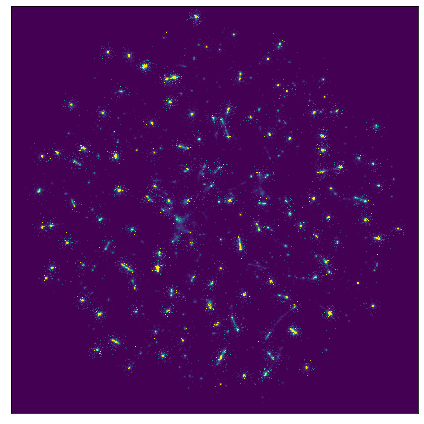

In [29]:
hist2d, edgesX, edgesY = draw_2D_hist(df_Alu)
plt.savefig("All_all.pdf")

Pixels ignored: 1772 pixels in 5496 cntours
Big contours: 11671 pixels in 147 cntours
Small contour: 2705 piexels in 382 cntours
CPU times: user 1.68 s, sys: 159 ms, total: 1.84 s
Wall time: 1.55 s


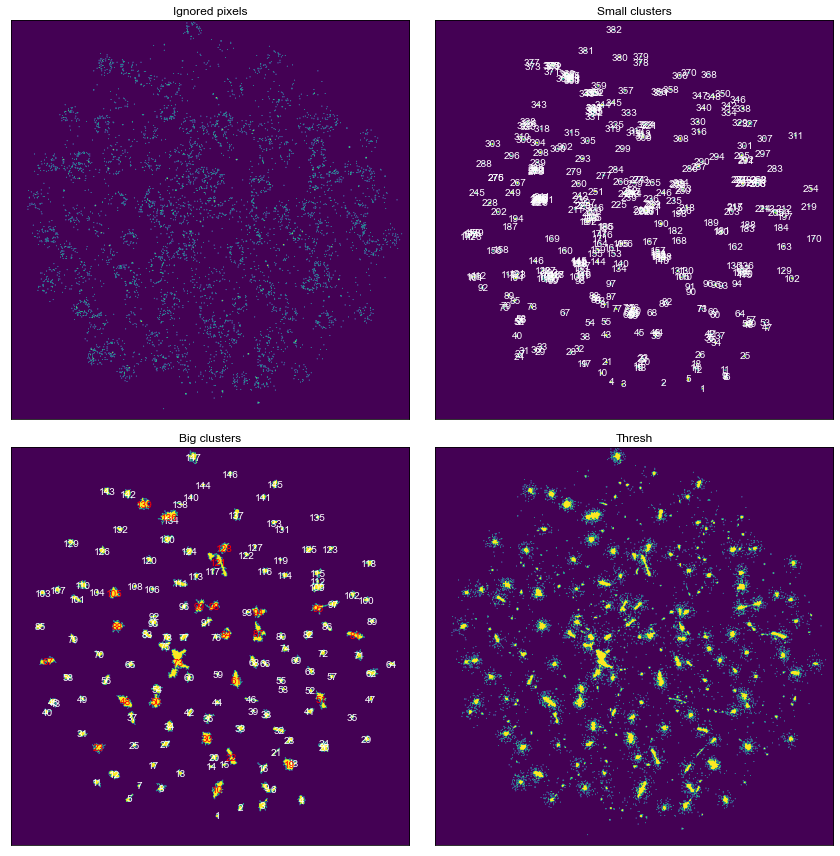

In [22]:
%time mall_clusters, big_clusters =  hist_to_spots(hist2d, density=True, cutoff=0.001*255, show_big_clusters_id=True)
plt.savefig("Alu.figure.pdf")

Pixels ignored: 1772 pixels in 5496 cntours
Big contours: 11671 pixels in 147 cntours
Small contour: 2705 piexels in 382 cntours


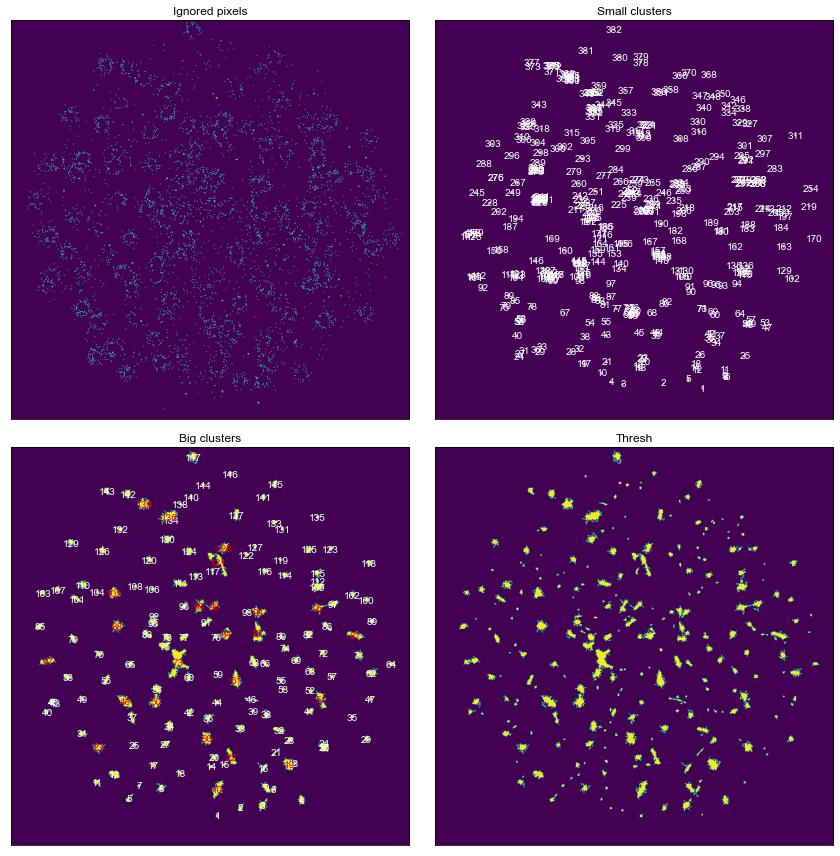

In [28]:
mall_clusters, big_clusters = hist_to_spots_2(hist2d, density=True, cutoff=0.001*255, show_big_clusters_id=True)
plt.savefig("Alu.2.figure.pdf")

In [33]:
%time df_Alu_spots = retrive_clusters(df_Alu, edgesX, edgesY, big_clusters, cluster_ids=None, spot_name="Big")

CPU times: user 38min 42s, sys: 1min 58s, total: 40min 40s5052
Wall time: 11min 25s


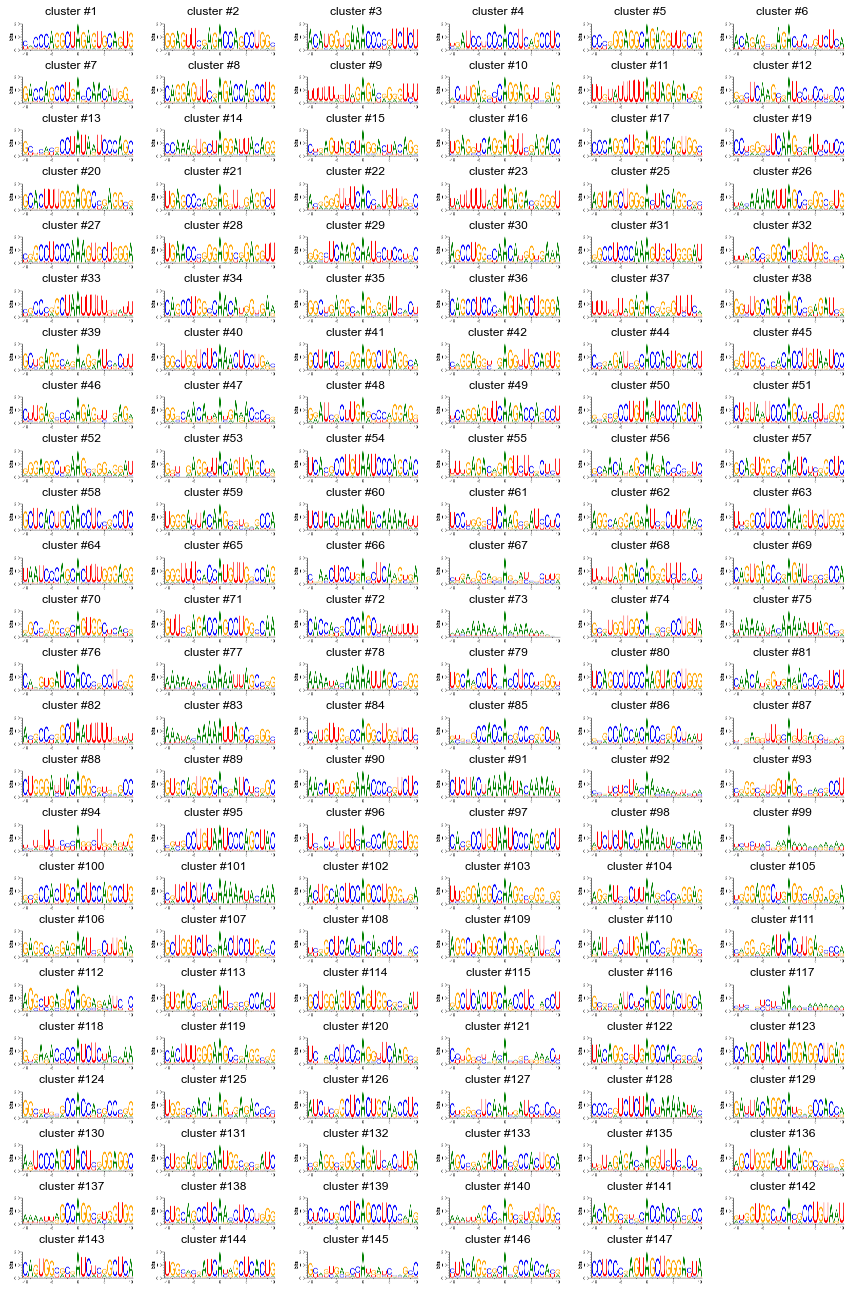

In [86]:
show_logos_cols("./bigs2/logos_bits_png/", cols=6)
plt.savefig("Alu_all_motifs.png", dpi=300)

## 2. Non-Alu repeats

In [11]:
df_REP = pd.read_csv("./REDIportal_hg38.F10.REP.retrived.UMAP.csv", index_col=0, header=0)
print(df_REP.shape)

(999240, 11)


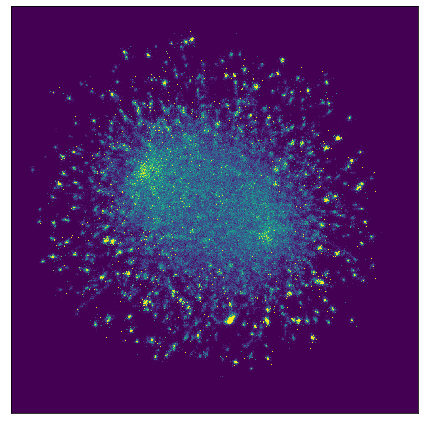

In [13]:
hist2d_REP, edgesX_REP, edgesY_REP = draw_2D_hist(df_REP, xlim=[-8,8], ylim=[-8,8])

Pixels ignored: 23111 pixels in 14724 cntours
Big contours: 9589 pixels in 2 cntours
Small contour: 7651 piexels in 98 cntours
CPU times: user 561 ms, sys: 107 ms, total: 668 ms
Wall time: 452 ms


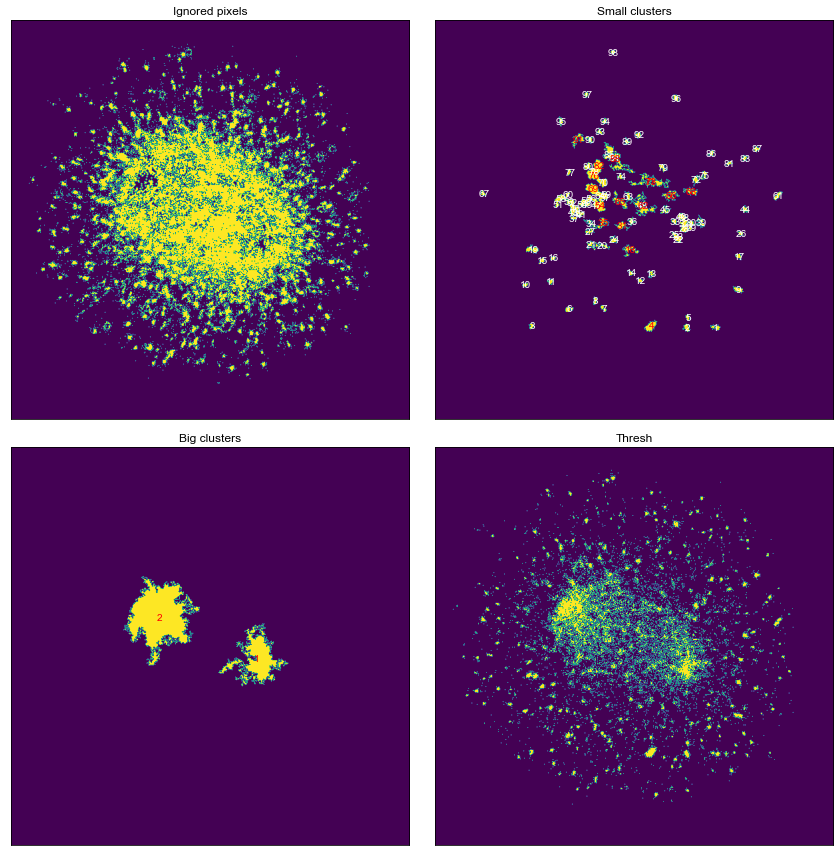

In [14]:
%time small_clusters_REP, big_clusters_REP = hist_to_spots(hist2d_REP, density=True, cutoff=0.01*255, show_big_clusters_id=True, pixel_lower = 20, pixel_upper =500)
plt.savefig("REP.figure.pdf")

Pixels ignored: 23111 pixels in 14724 cntours
Big contours: 9589 pixels in 2 cntours
Small contour: 7651 piexels in 98 cntours
CPU times: user 511 ms, sys: 116 ms, total: 627 ms
Wall time: 426 ms


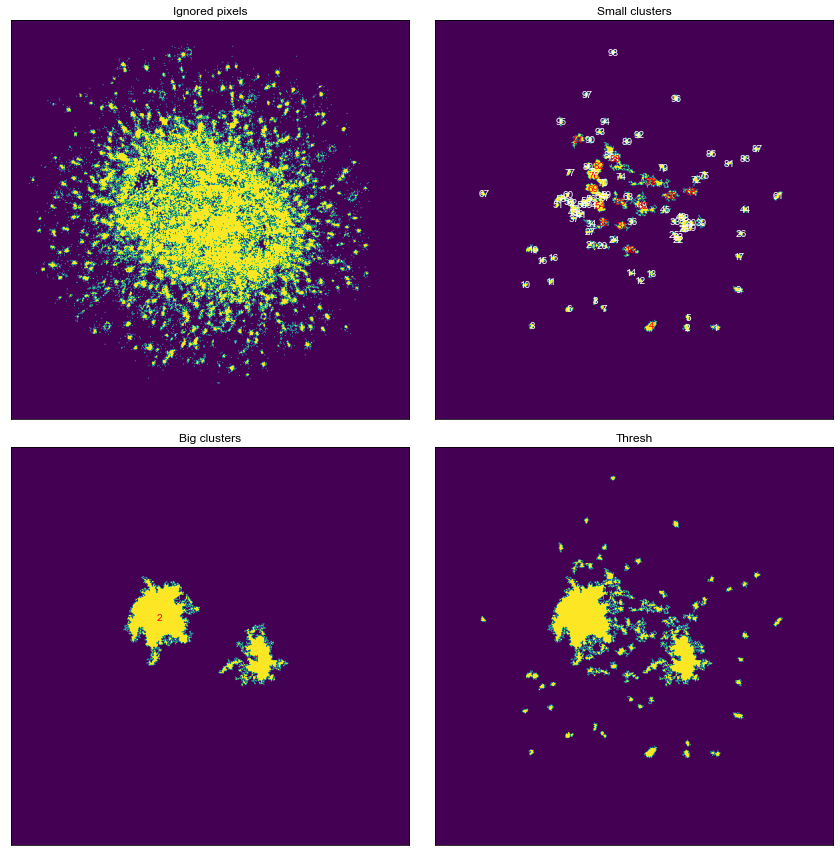

In [15]:
%time small_clusters_REP, big_clusters_REP = hist_to_spots_2(hist2d_REP, density=True, cutoff=0.01*255, show_big_clusters_id=True, pixel_lower = 20, pixel_upper =500)
plt.savefig("REP.2.figure.pdf")

In [16]:
%time df_REP_spots = retrive_clusters(df_REP, edgesX_REP, edgesY_REP, big_clusters_REP, spot_name="Big")

CPU times: user 33.7 s, sys: 458 ms, total: 34.2 s: 149154
Wall time: 31.8 s


In [17]:
%time df_REP_spots_small = retrive_clusters(df_REP, edgesX_REP, edgesY_REP, small_clusters_REP, spot_name="Small")

CPU times: user 26.2 s, sys: 430 ms, total: 26.6 ss: 135017
Wall time: 24.7 s


In [61]:
# merge small clusters
df_REP_spots_small2 = df_REP_spots_small.copy()
cluster1_indexes = []
cluster2_indexes = []
cluster999_indexes = []
cluster998_indexes = []
cluster997_indexes = []

cluster1_ids = [33, 40, 39, 38, 32, 30, 29, 28, 25, 23, 22, 45]
cluster2_ids = [51, 58, 60, 53, 52, 46, 43, 42, 37, 41, 55, 50, 77, 69, 78, 80, 82, 76, 70, 56, 64, 49, 59, 57, 47, 54, 88, 74, 34, 35, 27]
cluster999_ids = [90, 91]

cluster1_ids = {i:1 for i in cluster1_ids}
cluster2_ids = {i:1 for i in cluster2_ids}
cluster999_ids = {i:1 for i in cluster999_ids}

for idx, row in df_REP_spots_small2.iterrows():
    if row["Spot_id"] in cluster1_ids:
        cluster1_indexes.append(idx)
    elif row["Spot_id"] in cluster2_ids:
        cluster2_indexes.append(idx)
    elif row["Spot_id"] in cluster999_ids:
        cluster999_indexes.append(idx)
    elif row["Spot_id"] == 1:
        cluster998_indexes.append(idx)
    elif row["Spot_id"] == 2:
        cluster997_indexes.append(idx)
        
df_REP_spots_small2.loc[cluster1_indexes, "Spot_id"] = 1
df_REP_spots_small2.loc[cluster2_indexes, "Spot_id"] = 2
df_REP_spots_small2.loc[cluster999_indexes, "Spot_id"] = 999
df_REP_spots_small2.loc[cluster998_indexes, "Spot_id"] = 998
df_REP_spots_small2.loc[cluster997_indexes, "Spot_id"] = 997

df_REP_spots_merged = pd.concat([df_REP_spots, df_REP_spots_small2], axis=0)
print("==1==")
# reorder_indexes
all_ids = [i for i in range(1, 101)] + [997,998,999]

convert_ids = {}
N = 0
for id in all_ids:
    if df_REP_spots_merged[df_REP_spots_merged["Spot_id"] == id].shape[0] > 0:
        N += 1
        convert_ids[id] = N
print("==2==")
df_REP_spots_merged["Spot_id2"] = -1
df_REP_spots_merged["Spot_id2"] = df_REP_spots_merged.apply(lambda x: convert_ids.get(x["Spot_id"]), axis=1)
df_REP_spots_merged["Spot_id"] = df_REP_spots_merged["Spot_id2"]

==1==
==2==


In [56]:
def draw_annotated_plot(df):
    from collections import defaultdict
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal', 'box')
    print("==1==")
    Xs = {}
    Ys = {}
    N = 0
    
    all_ids = range(1, 99)
    for id in all_ids:
        subdf = df[df["Spot_id"] == id]
        if subdf.shape[0] > 0:
            Xs[id] = subdf["X"]
            Ys[id] = subdf["Y"]
        N += 1
        sys.stderr.write("{}\r".format(N))
    print("==2==")
    xlim = [-8, 8]
    ylim = [-8, 8]
    bins = [100, 100]
    vmax = 0.05
    norm = None
    cmin = None
    density = True
    
    hist2d, edgesX, edgesY, ax_hist = ax.hist2d(df["X"], df["Y"], range=[xlim, ylim], vmax=vmax, bins=bins, cmin=cmin, density=density, norm=norm) 
    print("==3==")
    for spot_id in Xs.keys():
        c_X = np.mean(Xs[spot_id])
        c_Y = np.mean(Ys[spot_id])
        ax.annotate(str(int(spot_id)), xy=(c_X, c_Y), c="white", ha="center", va="center") 
    plt.axis("off")
    plt.tight_layout()
    

==1==


==2==
==3==


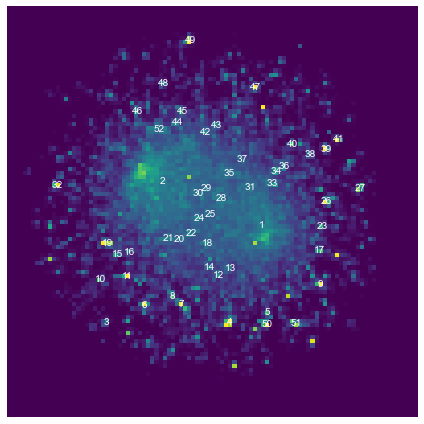

In [62]:
draw_annotated_plot(df_REP_spots_merged)
plt.savefig("REP_merged.pdf")

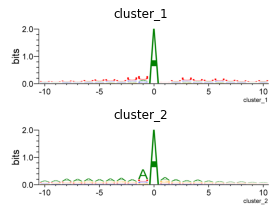

In [14]:
show_logos_cols("./bigs_rep/logos_bits_png/", cols=1)

In [98]:
extract_fasta_and_draw_motifs("small_rep2", df_REP_spots_small, cluster_col="Spot_id", motif_column="motif_F10", draw_logos=True)

===============  small_rep2  ===============
Empty DataFrame
Columns: [key, Region, Position, Strand, Ref, Ed, type, repeat, motif_F10, X, Y, Spot_name, Spot_id]
Index: []
Cluster #-1: 0
Empty DataFrame
Columns: [key, Region, Position, Strand, Ref, Ed, type, repeat, motif_F10, X, Y, Spot_name, Spot_id]
Index: []
Cluster #0: 0
                      key Region  Position Strand Ref Ed type       repeat  \
15240      chr1@1608316@+   chr1   1608316      +   A  G  REP    SINE/FRAM   
18147      chr1@1717012@-   chr1   1717012      -   T  C  REP  SINE/FLAM_C   
20593      chr1@1767770@-   chr1   1767770      -   T  C  REP  SINE/FLAM_C   
51107      chr1@6695257@-   chr1   6695257      -   T  C  REP  SINE/FLAM_C   
51113      chr1@6695280@-   chr1   6695280      -   T  C  REP  SINE/FLAM_C   
...                   ...    ...       ...    ...  .. ..  ...          ...   
15614430   chrY@7374408@+   chrY   7374408      +   A  G  ALU  SINE/AluSc8   
15617180  chrY@12329691@+   chrY  12329691      

Cluster #6: 2076
                       key Region   Position Strand Ref Ed type       repeat  \
42343       chr1@6226839@-   chr1    6226839      -   T  C  REP  SINE/FLAM_A   
46787       chr1@6557832@-   chr1    6557832      -   T  C  REP  SINE/FLAM_A   
51109       chr1@6695265@-   chr1    6695265      -   T  C  REP  SINE/FLAM_C   
53840       chr1@7722836@+   chr1    7722836      +   A  G  REP  SINE/FLAM_C   
68463       chr1@8795426@-   chr1    8795426      -   T  C  REP  SINE/FLAM_C   
...                    ...    ...        ...    ...  .. ..  ...          ...   
15594752  chrX@153939216@-   chrX  153939216      -   T  C  ALU   SINE/AluJo   
15601245  chrX@154493444@+   chrX  154493444      +   A  G  ALU   SINE/AluJb   
15605259  chrX@155045078@+   chrX  155045078      +   A  G  REP   LINE/L1MA9   
15606025  chrX@155271646@-   chrX  155271646      -   T  C  REP   LINE/L1MA3   
15634825   chrY@19738088@-   chrY   19738088      -   T  C  ALU  SINE/AluSx1   

                      

Cluster #11: 1677
                       key Region   Position Strand Ref Ed type  \
43000       chr1@6256789@-   chr1    6256789      -   T  C  REP   
198656     chr1@19248924@+   chr1   19248924      +   A  G  REP   
244627     chr1@22866550@-   chr1   22866550      -   T  C  REP   
253427     chr1@23477786@-   chr1   23477786      -   T  C  REP   
371381     chr1@32024911@+   chr1   32024911      +   A  G  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15606040  chrX@155271685@-   chrX  155271685      -   T  C  REP   
15607431  chrX@155530114@-   chrX  155530114      -   T  C  REP   
15609693    chrY@2964763@+   chrY    2964763      +   A  G  REP   
15624912   chrY@13373455@-   chrY   13373455      -   T  C  REP   
15635349   chrY@20401926@-   chrY   20401926      -   T  C  REP   

                 repeat              motif_F10         X         Y Spot_name  \
43000       SINE/FLAM_A  CGGGTGTGGGAGCACTTGCCC  0.227560 -2.444727     Small   
198656     DNA/Ti

Cluster #17: 1616
                      key Region  Position Strand Ref Ed type  \
5847       chr1@1250639@-   chr1   1250639      -   T  C  REP   
15202      chr1@1608104@+   chr1   1608104      +   A  G  REP   
38081      chr1@4457500@-   chr1   4457500      -   T  C  REP   
39641      chr1@6079821@+   chr1   6079821      +   A  G  REP   
54658      chr1@7790508@+   chr1   7790508      +   A  G  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15626927  chrY@13832588@+   chrY  13832588      +   A  G  REP   
15636428  chrY@20499128@-   chrY  20499128      -   T  C  REP   
15636609  chrY@20540953@-   chrY  20540953      -   T  C  REP   
15636793  chrY@20543786@-   chrY  20543786      -   T  C  REP   
15636987  chrY@20555680@-   chrY  20555680      -   T  C  REP   

                       repeat              motif_F10         X         Y  \
5847                LTR/LTR13  CAAGTCACCCAGGTGCCGAGG -0.266601 -1.090970   
15202     Simple_repeat/(AT)n  ATGTATGTATAATATATA

Cluster #24: 1156
                       key Region   Position Strand Ref Ed type  \
81338       chr1@9680461@-   chr1    9680461      -   T  C  REP   
223293     chr1@20988410@-   chr1   20988410      -   T  C  REP   
329831     chr1@28284002@+   chr1   28284002      +   A  G  REP   
489398     chr1@40523940@+   chr1   40523940      +   A  G  REP   
495595     chr1@41078229@-   chr1   41078229      -   T  C  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15586412  chrX@150019865@+   chrX  150019865      +   A  G  REP   
15629522   chrY@16062253@-   chrY   16062253      -   T  C  REP   
15632690   chrY@19042024@-   chrY   19042024      -   T  C  REP   
15636040   chrY@20493436@-   chrY   20493436      -   T  C  REP   
15636680   chrY@20542509@-   chrY   20542509      -   T  C  REP   

                       repeat              motif_F10         X         Y  \
81338              LINE/L1MB7  AAAATGTTTTAATTTTTTTTT  1.609167 -0.697069   
223293            DNA/Tig

Cluster #30: 551
                      key Region  Position Strand Ref Ed type  \
38376      chr1@5175247@-   chr1   5175247      -   T  C  REP   
43499      chr1@6348721@-   chr1   6348721      -   T  C  REP   
56163      chr1@7865610@-   chr1   7865610      -   T  C  REP   
116184    chr1@11171392@-   chr1  11171392      -   T  C  REP   
118221    chr1@11304114@+   chr1  11304114      +   A  G  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15635404  chrY@20415124@-   chrY  20415124      -   T  C  REP   
15636328  chrY@20497677@-   chrY  20497677      -   T  C  REP   
15636717  chrY@20543065@-   chrY  20543065      -   T  C  REP   
15636782  chrY@20543711@-   chrY  20543711      -   T  C  REP   
15638245  chrY@21628673@-   chrY  21628673      -   T  C  REP   

                    repeat              motif_F10         X         Y  \
38376           LTR/MLT1A0  AAAAAACAAAAATTTATTTCT -0.392397 -0.262905   
43499           LTR/MLT1A0  GAACAATGGAAATGCATTTCT -0.365

Cluster #35: 1381
                      key Region  Position Strand Ref Ed type  \
129407    chr1@12119847@-   chr1  12119847      -   T  C  REP   
140475    chr1@14345524@+   chr1  14345524      +   A  G  REP   
146004    chr1@14955949@+   chr1  14955949      +   A  G  REP   
165161    chr1@15839013@-   chr1  15839013      -   T  C  REP   
176276    chr1@16434214@-   chr1  16434214      -   T  C  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15620606  chrY@12717132@+   chrY  12717132      +   A  G  REP   
15632766  chrY@19045314@-   chrY  19045314      -   T  C  REP   
15632767  chrY@19045315@-   chrY  19045315      -   T  C  REP   
15632780  chrY@19045359@-   chrY  19045359      -   T  C  REP   
15637048  chrY@20556794@-   chrY  20556794      -   T  C  REP   

                    repeat              motif_F10         X         Y  \
129407           LINE/L1M5  TGTGACCAGCACAATGACCTA -0.037049 -0.137938   
140475           DNA/MER33  AGAATCATTGAGATATATTAC -0.14

                       key Region   Position Strand Ref Ed type  \
3600        chr1@1099242@+   chr1    1099242      +   A  G  REP   
5799        chr1@1250460@-   chr1    1250460      -   T  C  REP   
72330       chr1@9097830@-   chr1    9097830      -   T  C  REP   
118080     chr1@11298578@+   chr1   11298578      +   A  G  REP   
141232     chr1@14433972@+   chr1   14433972      +   A  G  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15591259  chrX@153469329@-   chrX  153469329      -   T  C  ALU   
15610625    chrY@3195396@-   chrY    3195396      -   T  C  REP   
15611357    chrY@6916744@+   chrY    6916744      +   A  G  REP   
15636932   chrY@20554344@-   chrY   20554344      -   T  C  REP   
15637699   chrY@20934472@+   chrY   20934472      +   A  G  REP   

                         repeat              motif_F10         X         Y  \
3600                 LINE/L1ME2  TCTAAGAATCAGAGAGAGAGA -2.535363  0.363515   
5799                  LTR/LTR13  AAACCA

                       key Region   Position Strand Ref Ed type  \
6234        chr1@1253018@-   chr1    1253018      -   T  C  REP   
6261        chr1@1253149@-   chr1    1253149      -   T  C  REP   
108707     chr1@10503338@+   chr1   10503338      +   A  G  REP   
123470     chr1@11807865@+   chr1   11807865      +   A  G  REP   
130513     chr1@12204880@+   chr1   12204880      +   A  G  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15607821  chrX@155648767@+   chrX  155648767      +   A  G  REP   
15626154   chrY@13485992@+   chrY   13485992      +   A  G  REP   
15632646   chrY@19041780@-   chrY   19041780      -   T  C  REP   
15633570   chrY@19514208@-   chrY   19514208      -   T  C  REP   
15637704   chrY@21036268@-   chrY   21036268      -   T  C  REP   

                          repeat              motif_F10         X         Y  \
6234                  LTR/LTR13_  ATACAAGGCAAGGGGGCAGGG -2.153496  0.631859   
6261                  LTR/LTR13_  ATG

Cluster #54: 2603
                       key Region   Position Strand Ref Ed type  \
4186        chr1@1113796@-   chr1    1113796      -   T  C  REP   
5753        chr1@1250015@-   chr1    1250015      -   T  C  REP   
35738       chr1@3801324@-   chr1    3801324      -   T  C  REP   
38454       chr1@5627391@-   chr1    5627391      -   T  C  REP   
52651       chr1@7063122@+   chr1    7063122      +   A  G  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15586880  chrX@150183975@+   chrX  150183975      +   A  G  REP   
15586978  chrX@150318490@+   chrX  150318490      +   A  G  REP   
15589340  chrX@152204992@-   chrX  152204992      -   T  C  REP   
15635391   chrY@20403017@-   chrY   20403017      -   T  C  REP   
15636026   chrY@20490835@-   chrY   20490835      -   T  C  REP   

                   repeat              motif_F10         X         Y  \
4186            LTR/MER50  GAGACGTAACACCCCGGAAGC -1.927883  0.775957   
5753            LTR/LTR13  AGCAGA

Cluster #61: 1994
                      key Region  Position Strand Ref Ed type  \
1075        chr1@778348@-   chr1    778348      -   T  C  REP   
4018       chr1@1112758@+   chr1   1112758      +   A  G  REP   
4152       chr1@1113613@-   chr1   1113613      -   T  C  REP   
5769       chr1@1250216@-   chr1   1250216      -   T  C  REP   
5779       chr1@1250382@-   chr1   1250382      -   T  C  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15636661  chrY@20541991@-   chrY  20541991      -   T  C  REP   
15636690  chrY@20542574@-   chrY  20542574      -   T  C  REP   
15636860  chrY@20549873@-   chrY  20549873      -   T  C  REP   
15636888  chrY@20553473@-   chrY  20553473      -   T  C  REP   
15637164  chrY@20557994@-   chrY  20557994      -   T  C  REP   

                    repeat              motif_F10         X         Y  \
1075             SINE/FRAM  AGCTACTTGAACCCAAAGGTT  0.052109  0.649213   
4018             LTR/MER50  AGACCCCAGAAGCCTGCCAGG  0.44

                      key Region  Position Strand Ref Ed type  \
6237       chr1@1253027@+   chr1   1253027      +   A  G  REP   
81337      chr1@9680447@-   chr1   9680447      -   T  C  REP   
95727     chr1@10141312@+   chr1  10141312      +   A  G  REP   
120162    chr1@11644304@-   chr1  11644304      -   T  C  ALU   
124768    chr1@11909899@-   chr1  11909899      -   T  C  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15636133  chrY@20495982@-   chrY  20495982      -   T  C  REP   
15636827  chrY@20545879@-   chrY  20545879      -   T  C  REP   
15636894  chrY@20553501@-   chrY  20553501      -   T  C  REP   
15637155  chrY@20557663@-   chrY  20557663      -   T  C  REP   
15637173  chrY@20558066@-   chrY  20558066      -   T  C  REP   

                    repeat              motif_F10         X         Y  \
6237            LTR/LTR13_  CTTGCCTTGTATCCAATAAAT  1.341007  0.826006   
81337          SINE/FLAM_C  TTTTTTTTTTAATAGAGACAG  1.603945  1.050173   


Cluster #72: 1417
                      key Region  Position Strand Ref Ed type  \
1401        chr1@800215@-   chr1    800215      -   T  C  REP   
2182        chr1@990704@+   chr1    990704      +   A  G  REP   
2183        chr1@990705@+   chr1    990705      +   A  G  REP   
6123       chr1@1252462@+   chr1   1252462      +   A  G  REP   
32132      chr1@2422700@+   chr1   2422700      +   A  G  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15637074  chrY@20557083@-   chrY  20557083      -   T  C  REP   
15637820  chrY@21209463@+   chrY  21209463      +   A  G  REP   
15638066  chrY@21287425@+   chrY  21287425      +   A  G  REP   
15638067  chrY@21287451@+   chrY  21287451      +   A  G  REP   
15638068  chrY@21287452@+   chrY  21287452      +   A  G  REP   

                    repeat              motif_F10         X         Y  \
1401            LINE/L1PA7  CTATTTAATAAATGGTGTTGG  1.168394  1.493175   
2182            LINE/L1MEc  CCGTATTGAAAATCAGTTGAC  1.07

Cluster #79: 861
                      key Region  Position Strand Ref Ed type  \
116171    chr1@11171292@-   chr1  11171292      -   T  C  REP   
119677    chr1@11564622@+   chr1  11564622      +   A  G  REP   
139192    chr1@13990266@+   chr1  13990266      +   A  G  REP   
266283    chr1@24462962@+   chr1  24462962      +   A  G  REP   
366567    chr1@31456683@-   chr1  31456683      -   T  C  REP   
...                   ...    ...       ...    ...  .. ..  ...   
15632706  chrY@19044899@-   chrY  19044899      -   T  C  REP   
15635947  chrY@20473017@-   chrY  20473017      -   T  C  REP   
15635964  chrY@20475788@-   chrY  20475788      -   T  C  REP   
15635985  chrY@20487799@-   chrY  20487799      -   T  C  REP   
15636376  chrY@20497859@-   chrY  20497859      -   T  C  REP   

                            repeat              motif_F10         X         Y  \
116171                   SINE/FRAM  TCTTTAAAAAAGAAAGAAAGA -1.838631  2.239510   
119677                  LTR/MER66B  GTAA

Cluster #86: 996
                       key Region   Position Strand Ref Ed type       repeat  \
18082       chr1@1716027@+   chr1    1716027      +   A  G  REP    SINE/FRAM   
22719       chr1@1828824@-   chr1    1828824      -   T  C  REP  SINE/FLAM_C   
29376       chr1@2223327@-   chr1    2223327      -   T  C  REP  SINE/FLAM_C   
36696       chr1@3860163@+   chr1    3860163      +   A  G  REP  SINE/FLAM_C   
42336       chr1@6226811@+   chr1    6226811      +   A  G  REP  SINE/FLAM_A   
...                    ...    ...        ...    ...  .. ..  ...          ...   
15603440  chrX@154747583@-   chrX  154747583      -   T  C  ALU   SINE/AluJb   
15609340    chrY@2908230@+   chrY    2908230      +   A  G  ALU   SINE/AluJr   
15612478    chrY@7285077@+   chrY    7285077      +   A  G  ALU   SINE/AluJr   
15625586   chrY@13403825@-   chrY   13403825      -   T  C  REP     SINE/FAM   
15628631   chrY@14747613@+   chrY   14747613      +   A  G  ALU   SINE/AluJr   

                      

Cluster #91: 1884
                       key Region   Position Strand Ref Ed type       repeat  \
38546       chr1@5732238@-   chr1    5732238      -   T  C  REP  LINE/L1PA17   
52873       chr1@7189736@+   chr1    7189736      +   A  G  REP   LINE/L1PB1   
244528     chr1@22798088@+   chr1   22798088      +   A  G  REP     LINE/L2a   
283002     chr1@25605566@+   chr1   25605566      +   A  G  REP   LINE/L1MA8   
331200     chr1@28389210@+   chr1   28389210      +   A  G  REP   LINE/L1MA6   
...                    ...    ...        ...    ...  .. ..  ...          ...   
15607756  chrX@155628535@+   chrX  155628535      +   A  G  REP  LINE/L1PA10   
15609384    chrY@2924325@+   chrY    2924325      +   A  G  REP   LINE/L1PA7   
15626274   chrY@13508598@+   chrY   13508598      +   A  G  REP   LINE/L1PB2   
15626315   chrY@13685777@+   chrY   13685777      +   A  G  REP   LINE/L1PA8   
15636392   chrY@20497895@-   chrY   20497895      -   T  C  REP    LINE/L1M1   

                     

Cluster #96: 2929
                       key Region   Position Strand Ref Ed type  \
141944     chr1@14595289@+   chr1   14595289      +   A  G  REP   
252077     chr1@23420544@-   chr1   23420544      -   T  C  REP   
279086     chr1@25362096@+   chr1   25362096      +   A  G  REP   
496596     chr1@41165469@-   chr1   41165469      -   T  C  REP   
496629     chr1@41165612@-   chr1   41165612      -   T  C  REP   
...                    ...    ...        ...    ...  .. ..  ...   
15591139  chrX@153459116@-   chrX  153459116      -   T  C  REP   
15606192  chrX@155274152@+   chrX  155274152      +   A  G  REP   
15606910  chrX@155397995@+   chrX  155397995      +   A  G  REP   
15612153    chrY@7190742@-   chrY    7190742      -   T  C  REP   
15635755   chrY@20442017@-   chrY   20442017      -   T  C  REP   

                 repeat              motif_F10         X         Y Spot_name  \
141944        LINE/L1M4  CCATTGTGGAAAACATATTAG -1.957845  5.030497     Small   
252077       LINE

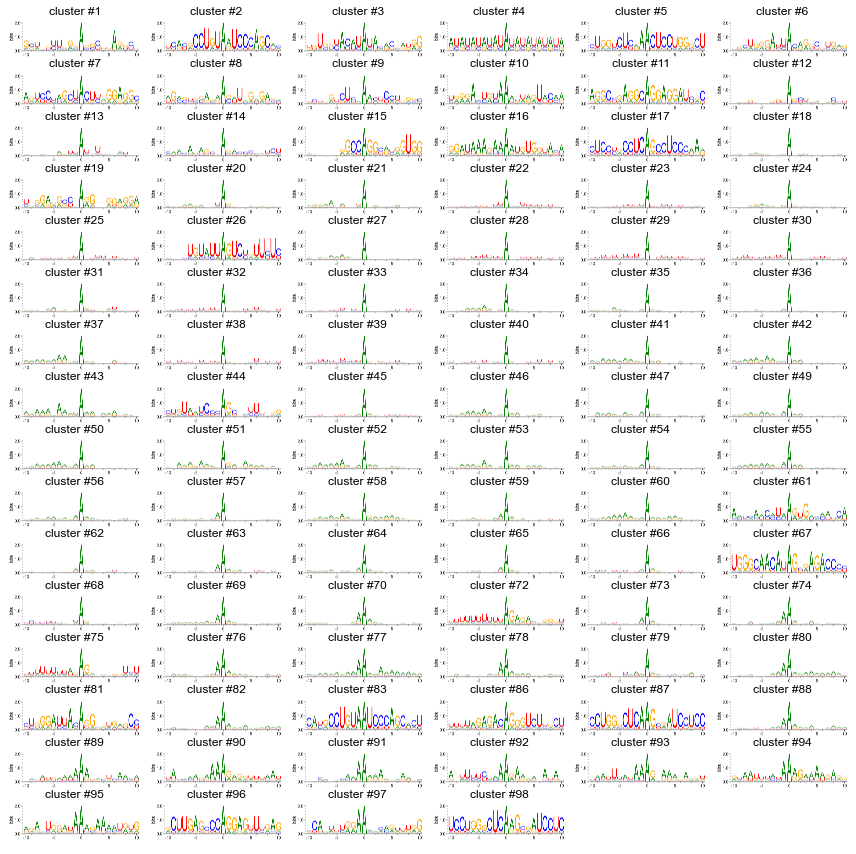

In [9]:
show_logos_cols("./small_rep2/logos_bits_png/", cols=6)
plt.savefig("REP_clusters.pdf", dpi=300)

In [71]:
extract_fasta_and_draw_motifs("small_rep_merged", df_REP_spots_merged, cluster_col="Spot_id", motif_column="motif_F10", draw_logos=True)

===============  small_rep_merged  ===============
Cluster #-1: 0
Cluster #0: 0
Cluster #1: 51610
Cluster #2: 142263
Cluster #3: 798
Cluster #4: 5918
Cluster #5: 777
Cluster #6: 2076
Cluster #7: 1823
Cluster #8: 1221
Cluster #9: 2402
Cluster #10: 891
Cluster #11: 1677
Cluster #12: 629
Cluster #13: 618
Cluster #14: 591
Cluster #15: 956
Cluster #16: 628
Cluster #17: 1616
Cluster #18: 1881
Cluster #19: 3979
Cluster #20: 1240
Cluster #21: 1054
Cluster #22: 1156
Cluster #23: 770
Cluster #24: 1605
Cluster #25: 790
Cluster #26: 1592
Cluster #27: 1994
Cluster #28: 5244
Cluster #29: 957
Cluster #30: 2196
Cluster #31: 1868
Cluster #32: 1838
Cluster #33: 1510
Cluster #34: 1417
Cluster #35: 5957
Cluster #36: 930
Cluster #37: 861
Cluster #38: 743
Cluster #39: 1643
Cluster #40: 996
Cluster #41: 2563
Cluster #42: 623
Cluster #43: 915
Cluster #44: 732
Cluster #45: 808
Cluster #46: 1000
Cluster #47: 2929
Cluster #48: 765
Cluster #49: 1854
Cluster #50: 2783
Cluster #51: 2390
Cluster #52: 2911


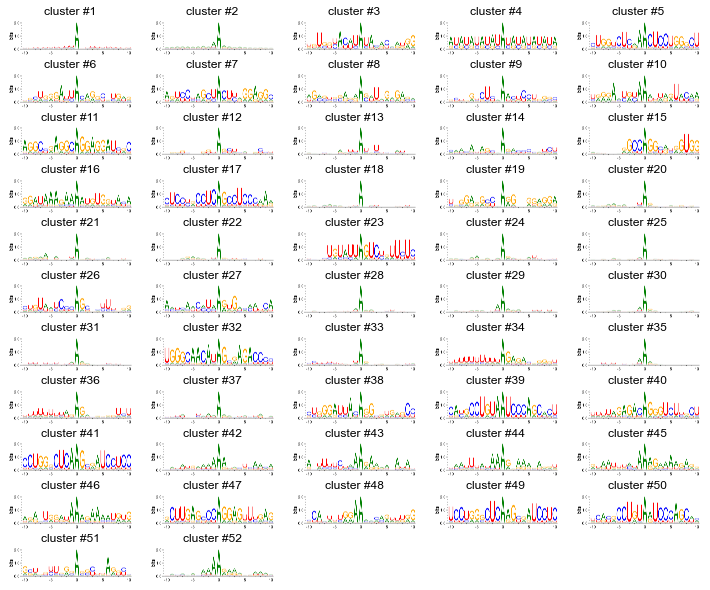

In [80]:
show_logos_cols("./small_rep_merged/logos_bits_png/", cols=5)
plt.savefig("REP_clusters.pdf", dpi=300)

## 3. non-repetitive 

In [16]:
df_NONREP = pd.read_csv("./REDIportal_hg38.F10.NONREP.retrived.UMAP.csv", index_col=0, header=0)
print(df_NONREP.shape)

(452563, 11)


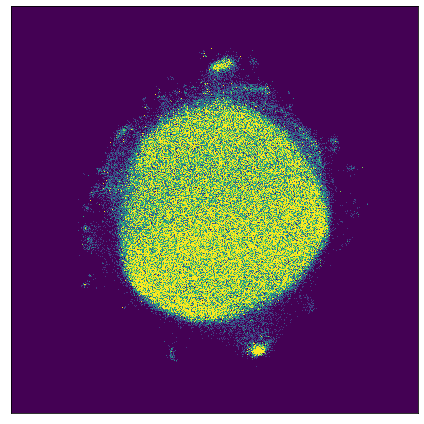

In [17]:
hist2d_NONREP, edgesX_NONREP, edgesY_NONREP = draw_2D_hist(df_NONREP, xlim=[-4.5, 5.5], ylim=[-6, 4])

Pixels ignored: 112640 pixels in 17749 cntours
Big contours: 83710 pixels in 1 cntours
Small contour: 2547 piexels in 21 cntours
CPU times: user 640 ms, sys: 63.5 ms, total: 703 ms
Wall time: 565 ms


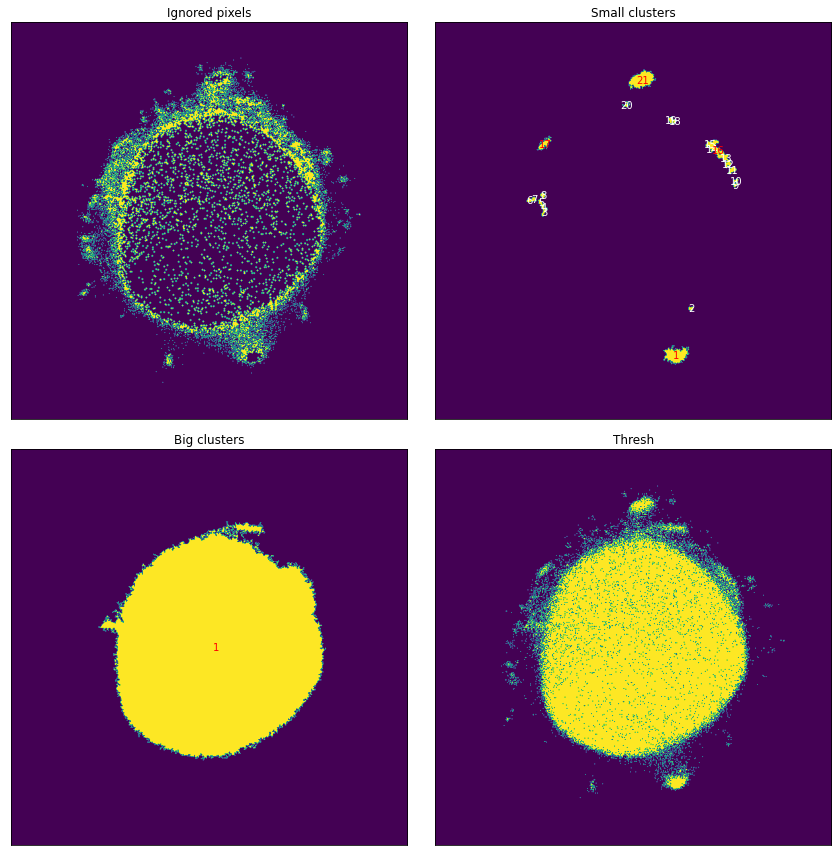

In [18]:
%time small_clusters_NONREP, big_clusters_NONREP = hist_to_spots(hist2d_NONREP, density=True, cutoff=0.005*255, show_big_clusters_id=True, pixel_lower = 20, pixel_upper =1000)
plt.savefig("NONREP.figure.pdf")

Pixels ignored: 112640 pixels in 17749 cntours
Big contours: 83710 pixels in 1 cntours
Small contour: 2547 piexels in 21 cntours


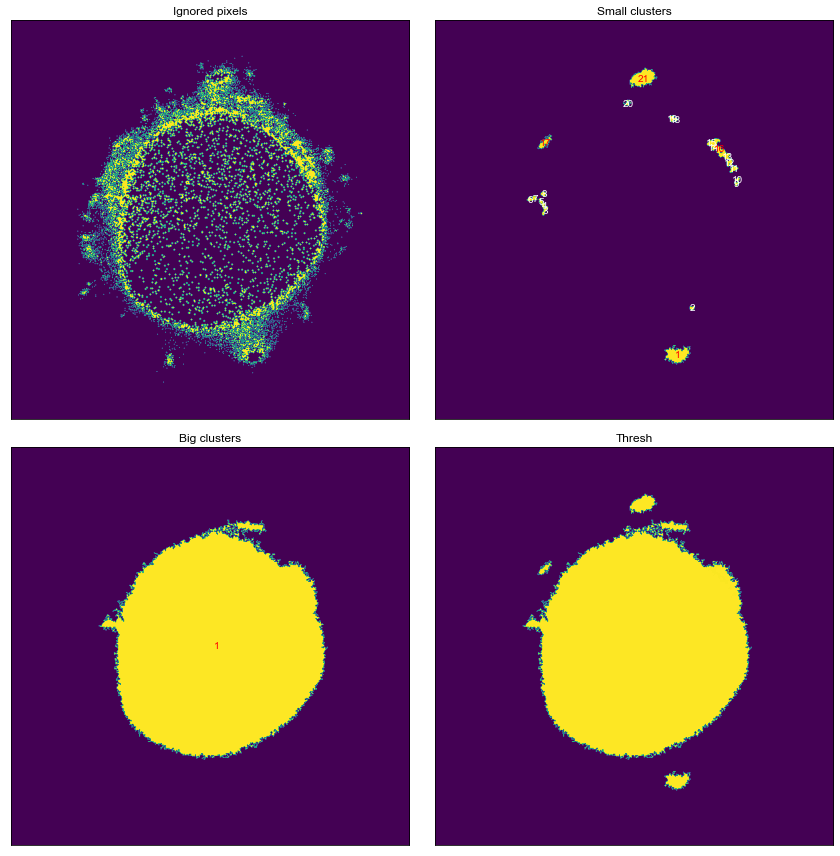

In [26]:
small_clusters_NONREP, big_clusters_NONREP = hist_to_spots_2(hist2d_NONREP, density=True, cutoff=0.005*255, show_big_clusters_id=True, pixel_lower = 20, pixel_upper =1000)
plt.savefig("NONREP.2.figure.pdf")

In [100]:
%time df_NONREP_spots_small = retrive_clusters(df_NONREP, edgesX_NONREP, edgesY_NONREP, small_clusters_NONREP, spot_name="Small")

CPU times: user 7 s, sys: 203 ms, total: 7.2 ssites: 7755
Wall time: 6.7 s


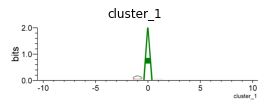

In [19]:
show_logos_cols("./big_NONREP/logos_bits_png/", cols=1)

In [101]:
extract_fasta_and_draw_motifs("small_NONREP2", df_NONREP_spots_small, cluster_col="Spot_id", motif_column="motif_F10", draw_logos=True)

===============  small_NONREP2  ===============
Empty DataFrame
Columns: [key, Region, Position, Strand, Ref, Ed, type, repeat, motif_F10, X, Y, Spot_name, Spot_id]
Index: []
Cluster #-1: 0
Empty DataFrame
Columns: [key, Region, Position, Strand, Ref, Ed, type, repeat, motif_F10, X, Y, Spot_name, Spot_id]
Index: []
Cluster #0: 0
                      key Region  Position Strand Ref Ed    type repeat  \
39857      chr1@6119722@-   chr1   6119722      -   T  C  NONREP    -/-   
39858      chr1@6119724@-   chr1   6119724      -   T  C  NONREP    -/-   
39859      chr1@6119728@-   chr1   6119728      -   T  C  NONREP    -/-   
39860      chr1@6119734@-   chr1   6119734      -   T  C  NONREP    -/-   
39861      chr1@6119740@-   chr1   6119740      -   T  C  NONREP    -/-   
...                   ...    ...       ...    ...  .. ..     ...    ...   
15615915  chrY@11903813@-   chrY  11903813      -   T  C  NONREP    -/-   
15615916  chrY@11903815@-   chrY  11903815      -   T  C  NONREP    -

                       key Region   Position Strand Ref Ed    type repeat  \
18846       chr1@1729682@-   chr1    1729682      -   T  C  NONREP    -/-   
127313     chr1@11978088@+   chr1   11978088      +   A  G  NONREP    -/-   
231076     chr1@21316577@-   chr1   21316577      -   T  C  NONREP    -/-   
795939    chr1@100074592@+   chr1  100074592      +   A  G  NONREP    -/-   
871146    chr1@115298423@+   chr1  115298423      +   A  G  NONREP    -/-   
...                    ...    ...        ...    ...  .. ..     ...    ...   
15414842   chrX@70474654@+   chrX   70474654      +   A  G  NONREP    -/-   
15440702   chrX@74278651@-   chrX   74278651      -   T  C  NONREP    -/-   
15510968  chrX@115631455@+   chrX  115631455      +   A  G  NONREP    -/-   
15533772  chrX@119854228@+   chrX  119854228      +   A  G  NONREP    -/-   
15545713  chrX@123913185@+   chrX  123913185      +   A  G  NONREP    -/-   

                      motif_F10         X         Y Spot_name  Spot_id  
18

Cluster #20: 138
                       key Region   Position Strand Ref Ed    type repeat  \
10311       chr1@1409166@+   chr1    1409166      +   A  G  NONREP    -/-   
10833       chr1@1428718@+   chr1    1428718      +   A  G  NONREP    -/-   
15266       chr1@1608440@+   chr1    1608440      +   A  G  NONREP    -/-   
18354       chr1@1725159@-   chr1    1725159      -   T  C  NONREP    -/-   
18844       chr1@1729679@-   chr1    1729679      -   T  C  NONREP    -/-   
...                    ...    ...        ...    ...  .. ..     ...    ...   
15603065  chrX@154555424@+   chrX  154555424      +   A  G  NONREP    -/-   
15612772    chrY@7305818@+   chrY    7305818      +   A  G  NONREP    -/-   
15614428    chrY@7374387@+   chrY    7374387      +   A  G  NONREP    -/-   
15628535   chrY@14731919@+   chrY   14731919      +   A  G  NONREP    -/-   
15631822   chrY@18984684@-   chrY   18984684      -   T  C  NONREP    -/-   

                      motif_F10         X         Y Spot_n

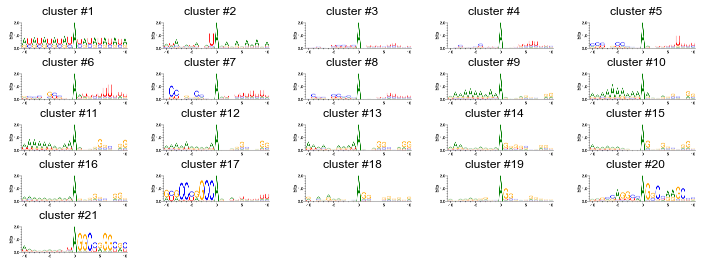

In [79]:
show_logos_cols("./small_NONREP2/logos_bits_png/", cols=5)
plt.savefig("NONREP_clusters.pdf", dpi=300)